# Autoproductie

## Overzicht
We kijken naar de dataset `cars.csv`, deze bevat informatie over de verkoop van 2e hands Volvo’s. We hebben hier een aantal vragen over, beantwoord deze vragen door een beetje code te schrijven en de antwoorden op te schrijven in een Jupyter Notebook.

In [71]:
# importeer libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
from scipy.stats import norm

In [72]:
# importeer dataset
df_cars = pd.read_csv(os.path.join('..', 'data', 'input', 'cars.csv'))

In [73]:
# importeer functies
sys.path.append('../scripts')  # definieer path met scripts
from fuel_mappings import fuel_mapping
from make_a_chart import horizontal_bar_chart

## Verkennen van het dataframe

In [74]:
# Print alle kolomnamen
print(df_cars.columns)

Index(['manufacturer', 'model', 'year', 'mileage', 'engine', 'transmission',
       'drivetrain', 'fuel_type', 'mpg', 'exterior_color', 'interior_color',
       'accidents_or_damage', 'one_owner', 'personal_use_only', 'seller_name',
       'seller_rating', 'driver_rating', 'driver_reviews_num', 'price_drop',
       'price'],
      dtype='object')


#### Verkennen van categorische variabelen

In [76]:
# Kolommen met datatype 'object' (categorische variabelen)
object_columns = df_cars.select_dtypes(include=['object']).columns.tolist()

# Maak een lijst om dictionaries met kolomnamen en unieke waarden in op te slaan
unique_values_list = []

# Doorloop de objectkolommen en bereken het aantal unieke waarden voor elke kolom
for column in object_columns:
    unique_values = df_cars[column].nunique()
    unique_values_list.append({'Column': column, 'Unique Values': unique_values})

# Converteer de lijst van dictionaries naar een dataframe en print het dataframe
unique_values_df = pd.DataFrame(unique_values_list)
print(unique_values_df)

           Column  Unique Values
0    manufacturer             30
1           model          12187
2          engine           6903
3    transmission           1313
4      drivetrain             33
5       fuel_type             36
6             mpg            865
7  exterior_color           7681
8  interior_color           4679
9     seller_name          18254


Voor onze analyse zijn de volgende niet-numerieke kolommen overbodig: model, engine, transmission, drivetrain, exterior_color, interior_color. We slaan het op als nieuw dataframe: df_cars_cleaned.

In [77]:
# Kolommen met datatype 'object' verwijderen die niet relevant zijn voor de analyse
df_cars_relevant = df_cars.drop(columns=['model',
                                         'engine',
                                         'transmission',
                                         'drivetrain',
                                         'mpg',
                                         'exterior_color',
                                         'interior_color',
                                         'seller_name'],
                                errors='ignore')

#### Verkennen van numerieke variabelen

In [78]:
# Samenvatting statistieken voor numerieke kolommen
summary_stats = df_cars.describe()

# Verwijder de kolommen met het gegevenstype 'object'
numerical_df = df_cars.select_dtypes(exclude=['object'])

# Gegevenstypen van elke kolom verkrijgen (zonder objectkolommen)
data_types_row = pd.DataFrame(numerical_df.dtypes, columns=['Gegevenstype']).T

# Beschrijvingsuitvoer samenvoegen met rij met gegevenstypen
combined_summary = pd.concat([data_types_row, summary_stats], axis=0)

# De samengevoegde samenvatting transponeren en afdrukken
print(combined_summary.T)

                    Gegevenstype     count          mean             std  \
year                       int64  762091.0   2017.791398        5.110532   
mileage                  float64  761585.0  55781.692701    43557.883284   
accidents_or_damage      float64  737879.0      0.228616        0.419942   
one_owner                float64  730608.0      0.561969        0.496145   
personal_use_only        float64  737239.0      0.657212        0.474642   
seller_rating            float64  548118.0      4.158568        0.805741   
driver_rating            float64  730459.0      4.623523        0.276902   
driver_reviews_num       float64  762091.0       89.5509      115.082266   
price_drop               float64  410112.0   1007.467068     1375.122208   
price                    float64  762091.0  36488.983085  1984183.263099   

                        min      25%      50%      75%           max  
year                 1915.0   2016.0   2019.0   2021.0        2024.0  
mileage              

Voor onze analyse zijn de volgende numerieke kolommen overbodig: one_owner, personal_use_only, driver_rating, driver_reviews_num, price_drop. Deze kolommen verwijderen we uit df_cars_cleaned.

In [8]:
# Kolommen (met datatype niet gelijk aan 'object') verwijderen die niet relevant zijn voor de analyse
df_cars_relevant = df_cars_relevant.drop(columns=['one_owner',
                                                  'personal_use_only',
                                                  'seller_rating',
                                                  'driver_rating', 
                                                  'driver_reviews_num', 
                                                  'price_drop'],
                                         errors='ignore')

Resultaat is een dataframe df_cars_cleaned met enkel kolommen die relevant zijn voor onze analyse.

In [ ]:
print(df_cars_relevant.columns)

## Data cleaning

#### Data cleaning van categorische variabelen
Laten we naar de verschillende waarden van de overgebleven categorische variabelen kijken om te bepalen of er fouten, inconsistenties,... te zien zijn.

In [79]:
# Een lijst printen van alle waarden van manufacturers
manufacturers = df_cars_relevant['manufacturer'].unique()
print(manufacturers)

['Acura' 'Audi' 'BMW' 'Buick' 'Cadillac' 'Chevrolet' 'Chrysler' 'Dodge'
 'Ford' 'GMC' 'Honda' 'Hyundai' 'INFINITI' 'Jaguar' 'Jeep' 'Kia'
 'Land Rover' 'Lexus' 'Lincoln' 'Mazda' 'Mercedes-Benz' 'Mitsubishi'
 'Nissan' 'Porsche' 'RAM' 'Subaru' 'Tesla' 'Toyota' 'Volkswagen' 'Volvo']


De lijst met manufacturers ziet er goed uit. Maar die van fuel_types kan wat datacleaning gebruiken, zoals je hieronder kan zien:

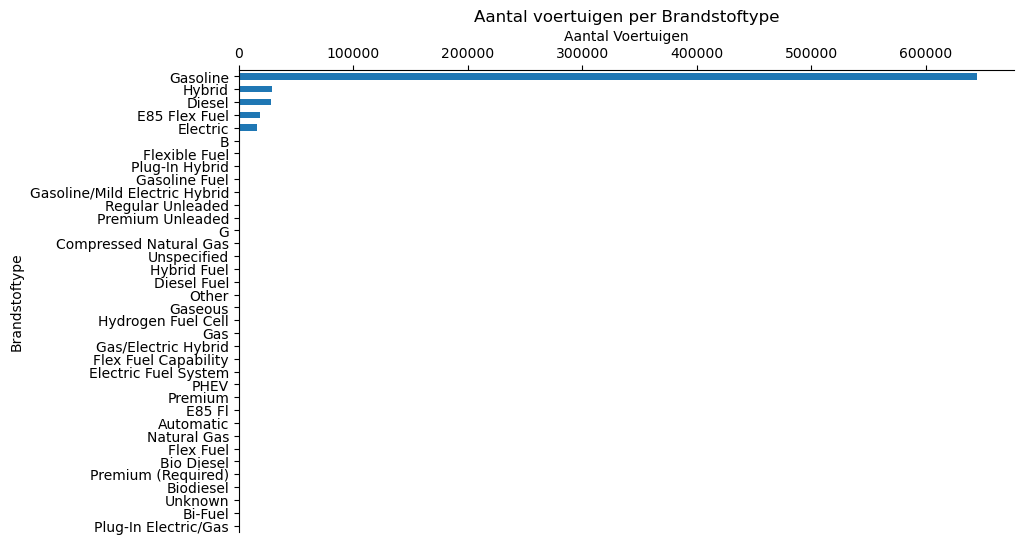

In [80]:
# We creëren een horizontale bar chart voor alle fuel_types, om te kijken hoe vaak elke fuel_type voorkomt
values_fuel_type = df_cars_relevant['fuel_type'].value_counts(ascending=True)
horizontal_bar_chart(values_fuel_type, 
                     'Aantal voertuigen per Brandstoftype',
                     'Aantal Voertuigen',
                     'Brandstoftype')

Dit zijn veel teveel types. We verkleinen het aantal categorieën met behulp van een mapping:

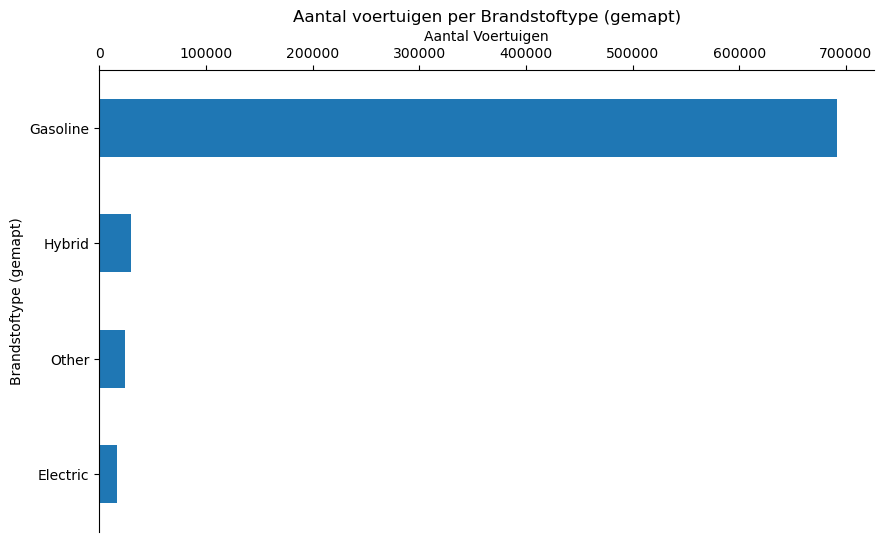

In [81]:
# Map the 'fuel_type' kolom in df_cars mbv de fuel mapping dictionary
df_cars_relevant['fuel_type_mapped'] = df_cars_relevant['fuel_type'].map(fuel_mapping)

# We creëren een horizontale bar chart voor alle fuel_types, NA mapping
values_mapped_fuel_type = df_cars_relevant['fuel_type_mapped'].value_counts(ascending=True)
horizontal_bar_chart(values_mapped_fuel_type, 'Aantal voertuigen per Brandstoftype (gemapt)', 'Aantal Voertuigen', 'Brandstoftype (gemapt)')

In [82]:
# Verwijder rijen waar 'fuel_type_mapped' gelijk is aan 'Other' en maak een kopie.
# Het gaat slechts om een klein deel van de data.
df_cars_cleaned = df_cars_relevant[df_cars_relevant['fuel_type_mapped'] != 'Other'].copy()

# Wijs de waarden van 'fuel_type_mapped' toe aan 'fuel_type' in df_cars_cleaned
df_cars_cleaned['fuel_type'] = df_cars_cleaned['fuel_type_mapped']

# Verwijder de 'fuel_type_mapped' kolom uit df_cars_cleaned
df_cars_cleaned.drop(columns=['fuel_type_mapped'], inplace=True)

#### Data cleaning van numerieke variabelen
Laten we naar de verschillende waarden van de overgebleven numerieke kolommen kijken om te bepalen of er fouten, inconsistenties,... te zien zijn.

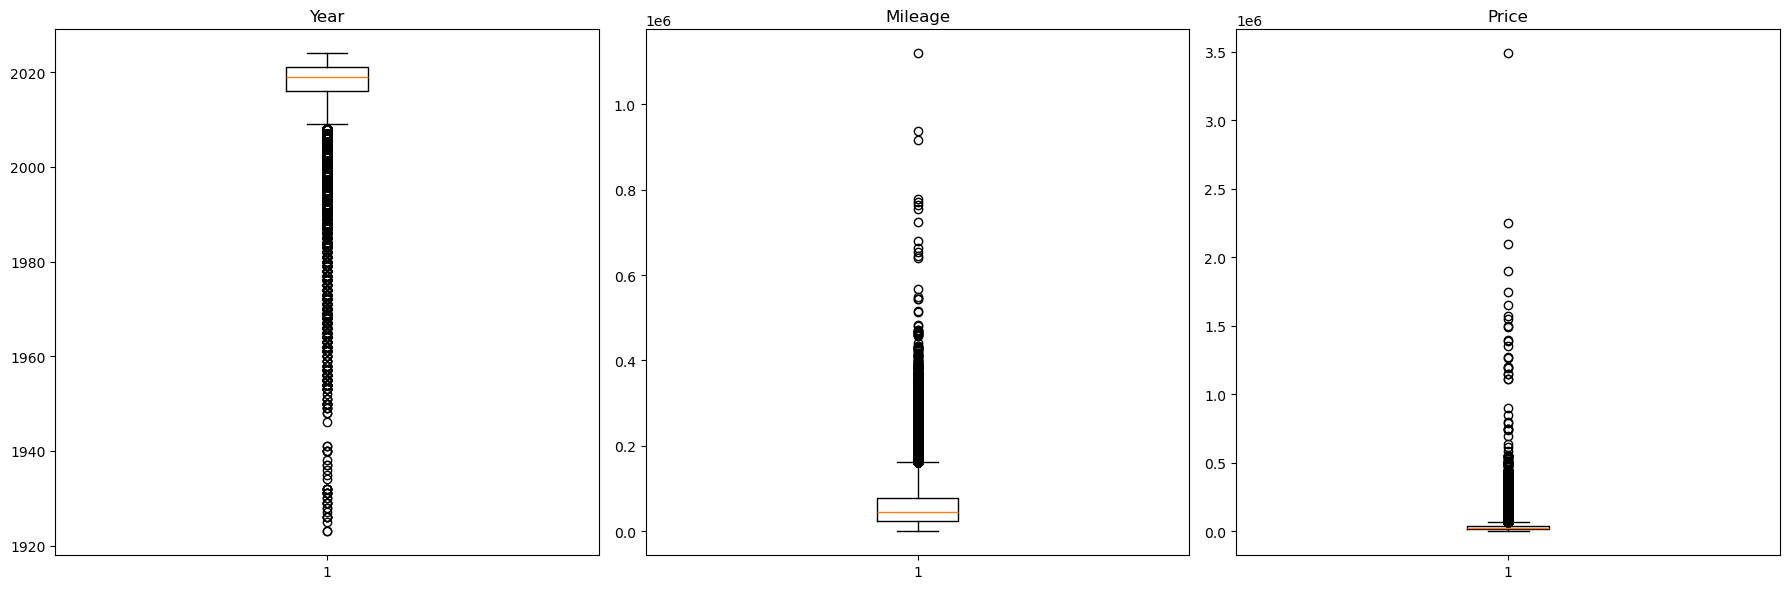

In [83]:
# Verwijder NaN-waarden uit de DataFrame
df_cars_cleaned.dropna(subset=['year', 'mileage', 'price'], inplace=True)

# Filter outliers op vlak van prijs en mileage weg. Deze nemen we niet mee in rest van de analyse
df_cars_cleaned = df_cars_cleaned[df_cars_cleaned['price'] <= 3500000]
# df_cars_cleaned = df_cars_cleaned[df_cars_cleaned['mileage'] <= 500000]

# Filter auto's met exacte mileage 999.999 weg omdat we niet zeker zijn of dit correct is
df_cars_cleaned = df_cars_cleaned[(df_cars_cleaned['mileage'] < 999998) | (df_cars_cleaned['mileage'] > 999999.9)]

# Selecteer de gewenste variabelen voor de boxplots
year_data = df_cars_cleaned['year']
mileage_data = df_cars_cleaned['mileage']
price_data = df_cars_cleaned['price']

# Maak een figuur met drie subplots in één rij
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot voor 'year'
axs[0].boxplot(year_data)
axs[0].set_title('Year')

# Boxplot voor 'mileage'
axs[1].boxplot(mileage_data)
axs[1].set_title('Mileage')

# Boxplot voor 'price'
axs[2].boxplot(price_data)
axs[2].set_title('Price')

plt.tight_layout()
plt.show()

De variabele 'year' ziet er degelijk uit. De meeste 2de hands auto's zijn zoals verwacht recent. Er zijn veel outliers aan de onderkant (oldtimers), maar dat is geen issue.

De variabele 'mileage' ziet er zoals verwacht uit: Het overgrote deel van de voertuigen heeft minder dan 200 000 miles gereden. En er zijn wat outliers aan de bovenkant. NaN-waarden werden verwijderd.

De variabele 'price' bevatte zeer extreme outliers (1 miljard en 5 miljoen). Deze filterden we eruit. Merk op dat er best wel wat auto's zijn met zeer hoge prijzen tot 3.5 miljoen die we behouden in de dataset.

Voor de variabele 'mileage' zijn er drie wagens met kilometerstand van exact 999.999. Deze filteren we eruit omdat we niet kunnen vertrouwen dat deze waarden correct zijn. De tabel hieronder toont de ongefilterde hoogste waarden voordat bovenstaande filters zijn toegepast.

In [84]:
# Verwijder NaN-waarden uit de DataFrame
df_cars_mile_price = df_cars_relevant.dropna(subset=['mileage', 'price'])

# Toon hoogste waarden
print('Top 10 price:')
print(df_cars_mile_price['price'].sort_values(ascending=False).head(10))

print('Top 10 mileage:')
# df_cars_test3 = df_cars_cleaned[(df_cars_cleaned['mileage'] < 999998) | (df_cars_cleaned['mileage'] > 999999.9)]
print(df_cars_mile_price['mileage'].sort_values(ascending=False).head(10))
  
# # Toon boxplot met alle waarden
# mileage_data = df_cars_mile_price['mileage']
# price_data = df_cars_mile_price['price']

# fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# # # Boxplot voor 'mileage'
# # axs[1].boxplot(mileage_data)
# # axs[1].set_title('Mileage')
# # axs[1].axhline(1000000, c='r')

# # Boxplot voor 'price'
# axs[0].boxplot(price_data)
# axs[0].set_title('Price')
# axs[0].axhline(10000000, c='r')

# plt.tight_layout()
# plt.show()

Top 10 price:
188113    1.000000e+09
108142    1.000000e+09
188260    1.000000e+09
84358     4.999999e+06
636956    3.490000e+06
613085    2.250000e+06
609009    2.099995e+06
613080    1.899999e+06
49078     1.750000e+06
613084    1.650000e+06
Name: price, dtype: float64
Top 10 mileage:
756847    1119067.0
76422      999999.0
494409     999999.0
511961     999999.0
617503     974302.0
319941     938032.0
522994     915383.0
136180     777698.0
669643     769938.0
229883     763474.0
Name: mileage, dtype: float64


### Vraag 1:
Wat voor soort data zijn `year`, `fuel_type` en `seller_rating`? Motiveer je antwoord.

Antwoord:
Bij het verkennen van de data (zie vorige hoofdstuk) kwamen we reeds tot de volgende conclusies:

**year**: numeriek (meer specifiek: integer)

**fuel_type**: categorisch (meer specifiek: niet-ordinaal, er is geen rangorde tussen deze categorieën)

**seller_rating**: kan zowel numeriek (meer specifiek: float, incl. potentiële NaN's) als categorisch (meer specifiek: ordinaal) geinterpreteerd worden, dit hangt af van de businessvraag.

### Vraag 2:
Ik vraag me af hoe een gewoonlijke (mbt prijs) $2^e$ hands Volvo eruit ziet. Kan je deze zoeken en tonen?

Antwoord: Zonder gedetailleerd naar de prijzen te kijken is de mediaan de veiligste centrummaat. Bij Vraag 3 kijken we ook naar andere centrummaten.

In [ ]:
# Maak dataframe met alleen volvo's voor hergebruik
df_cars_volvo = df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']

# Bereken mediaan prijs voor alle Volvo's, maar ook voor (on)beschadigde Volvo's
median_price_volvo = df_cars_volvo['price'].median()
median_price_volvo_accidents = df_cars_volvo[df_cars_volvo['accidents_or_damage'] == 1]['price'].median()
median_price_volvo_no_accidents = df_cars_volvo[df_cars_volvo['accidents_or_damage'] == 0]['price'].median()
                  
print(f"Mediaanprijs van een 2de hands Volvo: {round(median_price_volvo)}")
print(f"Mediaanprijs van een 2de hands Volvo met schade of ongelukken: {round(median_price_volvo_accidents)}")
print(f"Mediaanprijs van een 2de hands Volvo zonder schade of ongelukken: {round(median_price_volvo_no_accidents)}")

Zoals verwacht ligt de mediaanprijs van een Volvo met schade of ongelukken een pak lager dan de mediaanprijs van een 2de hands Volvo zonder schade of ongelukken. Hieronder tonen we wat gegevens van zo'n typische 'mediaan'-Volvo.

In [ ]:
# Voor het geval geen Volvo bestaat met mediaanprijs: Zoek Volvo die het dichtst mediaan benadert
volvo_median_price = (df_cars_volvo
                       # trek voor elke rij mediaan af van prijs:
                       .iloc[(df_cars_volvo['price']
                              -median_price_volvo) 
                       .abs()
                       # sorteer op resultaat aftrekking en selecteer laagste resultaatwaarde
                       .argsort()[:1]]   
                      )

volvo_median_price.T

In [ ]:
# voorwaardelijke selectie gebruiken om direct de rij te vinden die het dichtst bij de mediaanprijs ligt
volvo_median_price = df_cars_volvo.loc[(df_cars_volvo['price'] - median_price_volvo).abs().idxmin()]
volvo_median_price


### Vraag 3:
We kunnen de verdeling van de prijs van $2^e$ hands Volvo's voorstellen met een histogram:
 - Waar zou je verwachten dat het gemiddelde +/- ligt voor deze verdeling?
 - Waar zou je verwachten dat de mediaan +/- ligt?

Teken dit histogram met `.hist` en gebruik `.axvline` om de mediaan en het gemiddelde toe te voegen aan de plot. Komt dit overeen met je verwachting?

 - Kan je de emprisiche cumulatieve distributie functie tekenen voor de verdeling die overeenkomt met dit histogram (zie ook `scipy.stats.ecdf`).

In [ ]:
# Histogram van prijzen

# Berekening gemiddelde prijs van een 2de hands Volvo
avg_price_volvo = (df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']
                   ['price'].mean()
                  )

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']['price'], bins=30, color='skyblue', edgecolor='black')
ax.set_title("Verdeling van Prijzen van 2de hands Volvo's")
ax.set_xlabel('Prijs')
ax.set_ylabel("Aantal Auto's")

# Voeg verticale lijnen toe voor mediaan (rood) en gemiddelde (paars)
ax.axvline(median_price_volvo, color='red', linestyle='solid', linewidth=2, label='Mediaan')
ax.axvline(avg_price_volvo, color='purple', linestyle='solid', linewidth=2, label='Gemiddelde')

# Verwijder lijnen bovenaan en rechts
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Voeg grid toe
ax.grid(True)
plt.show()

Uit de grafiek leiden we af dat de prijsverdeling min of meer symmetrisch is, weliswaar met een iets zwaardere linkerkant. De linkerkant zal maken dat het gemiddelde lager zal zijn dan de mediaan, en dit wordt ook door de berekeningen bevestigd.

In [ ]:
# Berekening van ECDF
def ecdf(data):
    """Bereken ECDF voor een 1D array van data."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

# Data voor Volvo prijzen
volvo_prices = df_cars_cleaned[df_cars_cleaned['manufacturer'] == 'Volvo']['price']

# Bereken ECDF voor Volvo prijzen
x_volvo, y_volvo = ecdf(volvo_prices)

# Plot de ECDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(volvo_prices, bins=30, color='skyblue', edgecolor='black', cumulative=True, density=True, alpha=0.5, label='Histogram')
ax.plot(x_volvo, y_volvo, marker='.', linestyle='none', color='blue', label='ECDF')
ax.set_title("Verdeling en ECDF van Prijzen van 2de hands Volvo's")
ax.set_xlabel('Prijs')
ax.set_ylabel("Kans")
ax.legend()

# Voeg verticale lijnen toe voor mediaan (rood) en gemiddelde (paars)
ax.axvline(median_price_volvo, color='red', linestyle='solid', linewidth=2, label='Mediaan')
ax.axvline(avg_price_volvo, color='purple', linestyle='solid', linewidth=2, label='Gemiddelde')

# Verwijder lijnen bovenaan en rechts
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Voeg grid toe
ax.grid(True)
plt.show()


### Vraag 4:
Ik wil nu de verschillende fuel types vergelijken hoeveel deze kosten. Hiervoor maak ik volgende afbeelding met meerdere histogrammen hoe kunnen we deze beter maken? Welke alternatieven zijn er nog?

Antwoord: Er zijn veel meer 2de hands Volvo's met Gasoline dan met andere brandstoffen. Een vergelijking obv histogrammen (met absolute aantallen) is daarom moeilijk te maken. De schaling op de y-as is sterk verschillend, omdat er veel meer voertuigen in de database zijn met Gasoline als brandstof dan dat er voertuigen zijn met andere brandstoffen.

In [ ]:
# Unieke brandstoftypes
brandstoftypes = df_cars_cleaned['fuel_type'].unique()

# Subplots maken
fig, axes = plt.subplots(1, len(brandstoftypes), figsize=(15, 5))

# Histogram plotten voor elk brandstoftype
for i, brandstoftype in enumerate(brandstoftypes):
    ax = axes[i] if len(brandstoftypes) > 1 else axes  # Geval behandelen wanneer er slechts één brandstoftype is
    df_cars_cleaned[df_cars_cleaned['fuel_type'] == brandstoftype]['price'].plot(kind='hist', ax=ax)
    ax.set_title(brandstoftype)
    ax.set_xlabel('Prijs')
    ax.set_ylabel("Aantal auto's")

# Layout aanpassen
plt.tight_layout()

# Plot weergeven
plt.show()

Een densityplot is een betere manier om deze 3 categorieën te vergelijken, omdat bij een densityplot de oppervlakte onder elke curve steeds gelijk is aan 1. 

In [ ]:
# Definieer kleuren voor elk brandstoftype
kleuren = {'Gasoline': 'grey', 'Hybrid': 'orange', 'Electric': 'green', 'Other': 'purple'}

# Plot de KDE van de prijsverdeling voor alle brandstoftypes
plt.figure(figsize=(10, 6))
for brandstoftype, kleur in kleuren.items():
    brandstof_data = df_cars_cleaned[df_cars_cleaned['fuel_type'] == brandstoftype]
    sns.kdeplot(brandstof_data['price'].dropna(), label=brandstoftype, fill=True, color=kleuren[brandstoftype])

plt.title('Prijsverdeling voor Alle Brandstoftypes')
plt.xlabel('Prijs')
plt.ylabel('Dichtheid')
plt.legend()

plt.xlim(left=0)  # Ondergrens van de x-as
plt.xlim(right=250000)  # Bovengrens van de x-as

# Verwijder de rechter- en bovenlijnen
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

Aan de hand van bovenstaande grafiek kunnen we zeggen dat 2de hands auto's met Gasoline gemiddeld gezien goedkoper zijn dan elektrische auto's.

In [ ]:
# Lege dictionary om medians op te slaan
brandstof_medians = {}

# Bereken de mediaan voor elk brandstoftype
for brandstoftype in brandstoftypes:
    median_price = df_cars_cleaned[df_cars_cleaned['fuel_type'] == brandstoftype]['price'].median()
    brandstof_medians[brandstoftype] = median_price

# Print de medians per brandstoftype
for brandstoftype, median_price in brandstof_medians.items():
    print(f"Mediaan prijs voor {brandstoftype}: {median_price}")

### Vraag 5:
Gegeven volgende boxplots van de prijs van elektrische & benzine wagens, zijn volgende uitspraken waar/onwaar/niet te besluiten & leg uit:

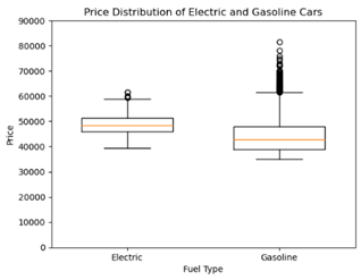

 - De spreiding op de prijs van elektrische wagens is groter dan die van benzinewagens.

 - Een wagen die meer dan 50 000 euro kost heeft een grotere kans om elektrisch te zijn dan benzine.

 - Een elektrische wagen heeft een grotere kans om meer dan 50 000 euro te kosten dan een benzine wagen.

Antwoord:
- **Onwaar**: Zowel de afstand min-max als de interkwartielafstand is groter bij benzinewagens dan bij elektrische wagens. Bovendien zijn er bij benzinewagens ook meer outliers.
- **Niet te besluiten**: Boxplots geven geen informatie over het aantal elektrische wagens vergeleken met het aantal benzinewagens. Indien er evenveel van beide zouden zijn, dan klopt de bewering wel. Maar indien er veel minder elektrische wagens dan benzinewagens zouden zijn, dan klopt de bewering niet.
- **Waar**: Bij benzinewagens ligt 75ste percentiel ongeveer op 50 000 euro. Bij elektrische wagens ligt mediaan net onder 50 000 euro, wat betekent dat iets minder dan de helft van de wagens meer kosten. Bij benzine ligt het 75%-percentiel ongeveer op 50 000, waardoor het aandeel benzinewagens met een prijs van >50 000 lager zal zijn dan het aandeel elektrische wagens met een prijs van >50 000.

### Vraag 6:
Maak een visualizatie om het verband tussen mileage & price te tonen?

Antwoord: Een goede visualisatie om het verband tussen 2 numerieke variabelen aan te tonen is een scatter plot.

In [ ]:
# Creëer scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cars_cleaned.mileage, df_cars_cleaned.price, color='skyblue', label='Data Points', s=1, alpha=0.5)

# Voeg labels en titel toe
plt.title('Correlatie tussen Mileage en Price')
plt.xlabel('Mileage')
plt.ylabel('Price')

# Voeg trendlijn toe
z = np.polyfit(df_cars_cleaned.mileage, df_cars_cleaned.price, 1)
p = np.poly1d(z)

# Genereer een reeks kilometerstandwaarden voor de trendlijn
# np.linspace genereert een reeks getallen (in dit geval kilometerstanden) die gelijkmatig verdeeld zijn over een gespecificeerd bereik.
# np.min(df_cars_cleaned.mileage) haalt de laagste kilometerstand in de dataset op, en np.max(df_cars_cleaned.mileage) de hoogste.
# We creëren 100 punten tussen deze twee extremen om een soepele trendlijn te krijgen.
mileage_range = np.linspace(np.min(df_cars_cleaned.mileage), np.max(df_cars_cleaned.mileage), 100)

# Plot de trendlijn
# Hier plotten we de trendlijn met 'mileage_range' als de x-waarden en 'p(mileage_range)' als de y-waarden.
# 'p' moet een eerder gedefinieerde functie zijn die de relatie tussen kilometerstand en een andere variabele (zoals prijs) modelleert.
# We kiezen de kleur 'rood' voor de trendlijn en geven het de label 'Trend Line'.
plt.plot(mileage_range, p(mileage_range), color='red', label='Trend Line')

# Voeg limieten voor x en y assen op basis van de datarange
plt.xlim(0, np.max(df_cars_cleaned.mileage) + 1000)
plt.ylim(0, np.max(df_cars_cleaned.price) + 1000)

# Verwijder de rechter- en bovenlijnen
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Voeg legende toe en toon de grafiek
plt.legend()
plt.grid(True)
plt.show()

We zien een zeer diffuus beeld. Het vermoeden is dat **de prijs** (en dus ook de correlatie tussen mileage en prijs) **sterk afhangt van het automerk en het feit of er al dan niet schade aan het voertuig is**. En dat blijkt uit onderstaande grafiek ook het geval.

In [ ]:
# Group by manufacturer and calculate average price and counts
manufacturer_stats = df_cars_cleaned.groupby('manufacturer')['price'].agg(
    Average_Price='mean',
    Count='count',
    Avg_Price_damage_1=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 1].mean(),
    Count_damage_1=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 1].count(),
    Avg_Price_damage_0=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 0].mean(),
    Count_damage_0=lambda x: x[df_cars_cleaned['accidents_or_damage'] == 0].count()
).reset_index()

# Sort the data by the longest bar
manufacturer_stats_longest_bar = manufacturer_stats.sort_values(by=['Average_Price', 'Avg_Price_damage_1', 'Avg_Price_damage_0'], ascending=True)

# Select data to plot
manufacturers = manufacturer_stats_longest_bar['manufacturer']
avg_price = manufacturer_stats_longest_bar['Average_Price']
avg_price_damage_1 = manufacturer_stats_longest_bar['Avg_Price_damage_1']
avg_price_damage_0 = manufacturer_stats_longest_bar['Avg_Price_damage_0']

# Set the positions of the bars on the x-axis
position = np.arange(len(manufacturers))

# Set the width of the bars
bar_width = 0.3

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(position - bar_width/1.5, avg_price_damage_1, height=bar_width, color='red', label='Average Price with Damage', alpha=0.7)
plt.barh(position + bar_width/1.5, avg_price_damage_0, height=bar_width, color='green', label='Average Price without Damage', alpha=0.7)
plt.barh(position, avg_price, height=bar_width*1.2, color='black', label='Average Price', alpha=1)

# Add labels and title
plt.xlabel('Average Price')
plt.ylabel('Manufacturer')
plt.yticks(position, manufacturers)
plt.title('Average Price vs. Average Price with/without Damage per Manufacturer')
plt.legend()

# Move x-axis to the top
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# Reverse legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels))

# Remove right and bottom spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

We kunnen per merk inzoomen op het verband tussen Price en Mileage. Zoals verwacht zien we voor elk merk een **negatieve correlatie**: Hoe meer kilometer er met een auto gereden werd, hoe minder die auto in het algemeen waard is. We werken in onderstaande afbeeldingen met slechts 10% van de data, owv de lange rekentijd. We gebruiken bij elke grafiek dezelfde schaal zodat we ze onderling kunnen vergelijken.

In alle grafieken (1 grafiek per merk) maakten we het onderscheid tussen voertuigen met schade (rood) en zonder schade (groen). Ook de trendlijnen zijn in de overeenkomstige kleur. Bij elk merk is de groene lijn (geen schade) steiler dan de rode trendlijn (wel schade): Een voertuig met weinig kilometers op de teller is meer waard als er geen schade of ongevallen waren.

In [ ]:
# Sample een klein deel van het dataframe
df_cars_sample = df_cars_cleaned.sample(frac=0.1, random_state=42)

# Bereken het aantal benodigde rijen voor het subplot grid
num_rows = (len(manufacturers) + 2) // 3  # Round up the division result

# Definieer kleuren voor de twee categorieën
color_mapping = {1: 'red', 0: 'green'}

# Maak subplots voor elke fabrikant
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6 * num_rows))

# Flatten de axes array om over alle subplots te itereren
axes_flat = axes.flatten()

for ax, manufacturer in zip(axes_flat, manufacturers):
    # Filter data voor de huidige fabrikant
    df_manufacturer = df_cars_sample[df_cars_sample['manufacturer'] == manufacturer]
    
    # Scatter plot met verschillende kleuren op basis van de kolom 'accidents_or_damage'
    sns.scatterplot(x='mileage', y='price', hue='accidents_or_damage', data=df_manufacturer, ax=ax, palette=color_mapping, s=6, alpha=0.5)

    # Filter datapunten zonder ongelukken of schade
    df_no_damage = df_manufacturer[df_manufacturer['accidents_or_damage'] == 0]
    # Plot trendlijn voor datapunten zonder ongelukken of schade (groen)
    sns.regplot(x='mileage', y='price', data=df_no_damage, ax=ax, scatter=False, color='green', label='Trendlijn (Geen Schade)')
    
    # Filter datapunten met ongelukken of schade
    df_damage = df_manufacturer[df_manufacturer['accidents_or_damage'] == 1]
    # Plot trendlijn voor datapunten met ongelukken of schade (rood)
    sns.regplot(x='mileage', y='price', data=df_damage, ax=ax, scatter=False, color='red', label='Trendlijn (Schade)')

    # Voeg labels en titel toe
    ax.set_title(f'Correlatie Kilometerstand en Prijs - {manufacturer}')
    ax.set_xlabel('Kilometerstand (mijlen)')
    ax.set_ylabel('Prijs ($)')

    # Stel limieten in voor x- en y-assen om 0 op te nemen
    ax.set_xlim(left=0, right=300000)
    ax.set_ylim(bottom=0, top=100000)

    # Voeg legende toe
    ax.legend(title='Accidenten of Schade')
    ax.grid(True)

# Verwijder eventuele ongebruikte subplots
for i in range(len(manufacturers), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

Als we even abstractie maken van het al dan niet hebben van schade, dan is onderstaande grafiek wat ons betreft de best mogelijke weergave om het verband tussen mileage en price aan te tonen: Voor alle merken wordt een auto minder waard naarmate er meer kilometers (of miles) op de teller staan. En sommige merken zijn bij aankoop een pak duurder dan andere. Merk op dat we in deze en alle voorgaande grafieken werkten met een lineaire trendlijn, hoewel het werkelijke verband niet noodzakelijk lineair hoeft te zijn (vb: Als een voertuig 100km rijdt, is de waardedaling wellicht veel groter in het geval er na het rijden van die 100km in totaal 100km op de teller staan, dan bij pakweg 100 000 km op de teller.)

In [ ]:
# Filter outliers op prijs en kilometerstand
df_cars_sample = df_cars.sample(frac=0.1, random_state=42)
df_cars_sample = df_cars_sample[(df_cars_sample.price < 1000000) & (df_cars_sample.mileage < 500000)]

# Haal unieke fabrikanten op
manufacturers = df_cars_sample['manufacturer'].unique()

# Bereken hellingen en intercepts voor elke fabrikant
slopes = {}
intercepts = {}
for manufacturer in manufacturers:
    df_manufacturer = df_cars_sample[df_cars_sample['manufacturer'] == manufacturer]
    X = df_manufacturer['mileage']
    y = df_manufacturer['price']
    X_mean = X.mean()
    y_mean = y.mean()
    slope = np.sum((X - X_mean) * (y - y_mean)) / np.sum((X - X_mean) ** 2)
    intercept = y_mean - slope * X_mean
    slopes[manufacturer] = slope
    intercepts[manufacturer] = intercept

# Sorteer fabrikanten op helling
sorted_manufacturers = sorted(manufacturers, key=lambda x: slopes[x], reverse=True)

# Maak scatterplot voor alle datapunten
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Wijs kleuren toe op basis van rang
colors = sns.color_palette('viridis', len(sorted_manufacturers))

for i, manufacturer in enumerate(sorted_manufacturers):
    # Filter data voor de huidige fabrikant
    df_manufacturer = df_cars_sample[df_cars_sample['manufacturer'] == manufacturer]
    
    # Genereer waarden voor regressielijn
    X = df_manufacturer['mileage']
    regression_line = slopes[manufacturer] * X + intercepts[manufacturer]
    
    # Plot regressielijn met label en kleur
    axs[0].plot(X, regression_line, label=manufacturer, color=colors[i])

# Voeg labels en titel toe voor de eerste subplot
axs[0].set_title('Correlatie Kilometerstand en Prijs per merk')
axs[0].set_xlabel('Kilometerstand (mijlen)')
axs[0].set_ylabel('Prijs ($)')
axs[0].set_xlim(left=0, right=300000)
axs[0].set_ylim(bottom=0, top=100000)
axs[0].grid(True)

# Voeg legende toe voor de tweede subplot
handles, labels = axs[0].get_legend_handles_labels()
legend = axs[1].legend(reversed(handles), reversed(labels), fontsize='large', loc='center', bbox_to_anchor=(0.5, 0.5), ncol=2)
legend.set_title('Fabrikanten', prop={'size': 'large'})

# Verberg de assen in de tweede subplot
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Vraag 7:
Volgens deze data is de gemiddelde prijs van $2^e$ hands elektrische Volvo’s 48 000 euro; als we veronderstellen dat onze dataset representatief is voor alle 2de hands volvo’s, hoe kan je de accuraatheid van deze schatting nagaan?

Antwoord: een standaarddeviatie van 4,162.03 euro geeft aan dat de prijzen van de elektrische tweedehands Volvo's gemiddeld ongeveer 4,162.03 euro afwijken van het gemiddelde van 48,788.39 euro. Op basis van het berekende betrouwbaarheidsinterval kunnen we met 95% zekerheid zeggen dat het werkelijke gemiddelde van alle elektrische tweedehands Volvo's ergens tussen de 48,275.54 euro en 49,301.24 euro ligt.

In [ ]:
# Filter de dataset op fuel_type 'electric'
df_cars_volvo_electric = df_cars_volvo[df_cars_volvo['fuel_type'] == 'Electric']

# Bereken het gemiddelde en de standaarddeviatie van de prijzen
avg_price_volvo_electric = df_cars_volvo_electric['price'].mean()
std_price_volvo_electric = df_cars_volvo_electric['price'].std()
median_price_volvo_electric = df_cars_volvo_electric['price'].median()

print(f"Geschatte gemiddelde prijs van elektrische tweedehands Volvo's: {avg_price_volvo_electric} euro")
print(f"Geschatte mediaan prijs van elektrische tweedehands Volvo's: {median_price_volvo_electric} euro")
print(f"Standaarddeviatie: {standaarddeviatie}")

# Bereken het betrouwbaarheidsinterval met 95% betrouwbaarheid
z_score = norm.ppf(0.975)  # Z-score voor 95% betrouwbaarheid
n = len(df_electric_volvo)
betrouwbaarheidsinterval = z_score * (standaarddeviatie / np.sqrt(n))
ondergrens = gemiddelde_prijs - betrouwbaarheidsinterval
bovengrens = gemiddelde_prijs + betrouwbaarheidsinterval

print(f"Betrouwbaarheidsinterval (95%): ({ondergrens}, {bovengrens})")

In [ ]:
# Histogram van prijzen
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_cars_volvo_electric['price'], bins=12, color='skyblue', edgecolor='black')
ax.set_title("Verdeling van Prijzen van 2de hands electric Volvo's")
ax.set_xlabel('Prijs')
ax.set_ylabel("Aantal Auto's")

# Voeg verticale lijnen toe voor mediaan (rood) en gemiddelde (paars)
ax.axvline(median_price_volvo_electric, color='red', linestyle='solid', linewidth=2, label='Mediaan')
ax.axvline(avg_price_volvo_electric, color='purple', linestyle='solid', linewidth=2, label='Gemiddelde')

# Verwijder lijnen bovenaan en rechts
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Voeg grid toe
ax.grid(True)
plt.show()